In [1]:
import os
import sys
sys.path.append('../../activedrops')
import autocorrelation

import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [3]:
def process_files_in_directory(directory_path):
    """
    Process all matching PIV files in the specified directory.
    
    Parameters:
    - directory_path (str): Path to the directory containing the PIV .txt files.
    
    Returns:
    - results (dict): Dictionary containing correlation lengths for each processed file.
    """
    
    # Dictionary to store the correlation length for each file
    results = {}
    
    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        # Check if the filename matches the pattern "PIVlab_****.txt"
        if filename.startswith("PIVlab_") and filename.endswith(".txt"):
            # Construct the full path to the file
            file_path = os.path.join(directory_path, filename)
            
            # Load and preprocess the data
            data = autocorrelation.load_and_convert_data(file_path)
            
            # Calculate the velocity autocorrelation
            R_u, R_v, R_uv = compute_velocity_autocorrelation_fourier(data)
            
            # Extract the radial form
            radial_autocorr = radial_velocity_autocorrelation(R_uv)
            distances = np.arange(len(radial_autocorr))
            
            # Adjust initial guesses for the exponential fit
            A_initial = np.max(radial_autocorr)
            B_initial = distances[np.abs(radial_autocorr - 0.5 * A_initial).argmin()]
            C_initial = radial_autocorr[-1]
            p0 = [A_initial, B_initial, C_initial]
            
            # Fit the radial autocorrelation to extract the correlation length
            lambda_val = fit_and_extract_lambda(distances, radial_autocorr, p0=p0)
            
            # Store the correlation length in the results dictionary
            results[filename] = lambda_val
            
            # Optionally: visualize the fit (commented out to avoid excessive plotting)
            # plot_exponential_fit_updated(distances, radial_autocorr, p0)
    
    return results

def compute_velocity_autocorrelation_fourier(data):
    """
    Compute the spatial autocorrelation of the velocity field using Fourier transforms.
    
    Parameters:
    - data (DataFrame): Data with columns ['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]'].
    
    Returns:
    - R_u (ndarray): Autocorrelation of the u-component of velocity.
    - R_v (ndarray): Autocorrelation of the v-component of velocity.
    - R_uv (ndarray): Combined autocorrelation.
    """
    
    # Extracting the u and v velocities and reshaping them to a 2D grid
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values by replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities by subtracting the mean
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)

    # Computing the Fourier transform of the normalized velocities
    F_u_norm = np.fft.fft2(u_norm)
    F_v_norm = np.fft.fft2(v_norm)
    
    # Calculating the power spectrum for both velocity components
    power_spectrum_u = np.abs(F_u_norm)**2
    power_spectrum_v = np.abs(F_v_norm)**2
    
    # Inverse Fourier transform of the power spectrum gives the autocorrelation
    R_u = np.fft.ifft2(power_spectrum_u).real
    R_v = np.fft.ifft2(power_spectrum_v).real
    
    # Shift the result to center the zero frequency component
    R_u = np.fft.fftshift(R_u)
    R_v = np.fft.fftshift(R_v)

    # Compute the combined autocorrelation
    R_uv = np.dot(R_u, R_v)
    
    return R_u, R_v, R_uv

def radial_velocity_autocorrelation(R):
    """
    Extract the radial form of a 2D autocorrelation matrix.
    
    Parameters:
    - R (ndarray): 2D autocorrelation matrix.
    
    Returns:
    - radial_mean (ndarray): Radial average of the autocorrelation matrix.
    """
    
    # Creating coordinate grids for the matrix
    y, x = np.indices((R.shape))
    
    # Computing the radial coordinate for each grid point
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    
    # Computing the radial average of the matrix
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean


def exponential_fit(r, A, B, C):
    """
    Exponential function for fitting purposes.
    
    Parameters:
    - r (ndarray): Radial distances.
    - A, B, C (float): Parameters of the exponential function.
    
    Returns:
    - ndarray: Values of the exponential function for the given radial distances.
    """
    return A * np.exp(-r / B) + C


def fit_and_extract_lambda(distances, radial_velocity, p0):
    """
    Fit the radial velocity autocorrelation to an exponential function and extract lambda.
    
    Parameters:
    - distances (ndarray): Radial distances.
    - radial_velocity (ndarray): Radial velocity autocorrelation.
    - p0 (list): Initial guesses for the fitting parameters [A, B, C].
    
    Returns:
    - lambda_val (float): Extracted correlation length.
    """
    
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=p0)
    
    # Extracting the correlation length lambda from the fit parameters
    A, B, C = popt
    lambda_val = -B * np.log((0.3 - C) / A)
    
    return lambda_val


def plot_exponential_fit(distances, radial_velocity, p0):
    """
    Fit the radial velocity autocorrelation to the exponential function with updated initial guesses and plot.
    
    Parameters:
    - distances (ndarray): Radial distances.
    - radial_velocity (ndarray): Radial velocity autocorrelation.
    - p0 (list): Initial guesses for the fitting parameters [A, B, C].
    """
    
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=p0)
    
    # Generating the exponential curve using the fitted parameters
    fitted_curve = exponential_fit(distances, *popt)
    
    # Plotting the original data and the fit
    plt.figure(figsize=(12, 6))
    plt.plot(distances, radial_velocity, 'b-', label="Original Data")
    plt.plot(distances, fitted_curve, 'r--', label="Exponential Fit")
    plt.xlabel("Distance (in microns)")
    plt.ylabel("Velocity Autocorrelation")
    plt.title("Velocity Autocorrelation and Exponential Fit with Updated Initial Guesses")
    plt.legend()
    plt.grid(True)
    plt.show()

# Process the files in the provided sample directory
results = process_files_in_directory("../../data/k401bio-250nM-piv/")  # Using "/mnt/data/" as it's where the sample files were uploaded
results


{'PIVlab_0001.txt': 36.25533699795435,
 'PIVlab_0002.txt': 52.53110089008176,
 'PIVlab_0003.txt': 43.78159919621346,
 'PIVlab_0004.txt': 55.01225077877021,
 'PIVlab_0005.txt': 45.83987397567383,
 'PIVlab_0006.txt': 37.437490550560426,
 'PIVlab_0007.txt': 37.975040379808625,
 'PIVlab_0008.txt': 36.16220497955741,
 'PIVlab_0009.txt': 36.64376290999941,
 'PIVlab_0010.txt': 34.32850263795904,
 'PIVlab_0011.txt': 34.66690636183601,
 'PIVlab_0012.txt': 33.908968343371114,
 'PIVlab_0013.txt': 34.356502767460924,
 'PIVlab_0014.txt': 33.56544054437629,
 'PIVlab_0015.txt': 32.74351415900938,
 'PIVlab_0016.txt': 33.81613366858664,
 'PIVlab_0017.txt': 35.36391840765722,
 'PIVlab_0018.txt': 32.975244622416945,
 'PIVlab_0019.txt': 32.51320272092489,
 'PIVlab_0020.txt': 31.907770450741836,
 'PIVlab_0021.txt': 32.192661279402515,
 'PIVlab_0022.txt': 31.131098715182905,
 'PIVlab_0023.txt': 31.34594822688602,
 'PIVlab_0024.txt': 31.787727859281798,
 'PIVlab_0025.txt': 31.489845271287873,
 'PIVlab_0026.t

In [22]:
# Transforming the results dictionary into a DataFrame
df_correlation_lengths = pd.DataFrame(list(results.items()), columns=['filename', 'correlation length'])

# Sorting the DataFrame based on the filename to ensure the correct order
df_correlation_lengths = df_correlation_lengths.sort_values(by='filename').reset_index(drop=True)

# Adding a column for time, calculated based on the filename
df_correlation_lengths['time (seconds)'] = df_correlation_lengths['filename'].str.extract('(\d+)').astype(int) * 3

# Re-ordering the columns
df_correlation_lengths = df_correlation_lengths[['time (seconds)', 'filename', 'correlation length']]

df_correlation_lengths


,time (seconds),filename,correlation length
0,3,PIVlab_0001.txt,36.255337
1,6,PIVlab_0002.txt,52.531101
2,9,PIVlab_0003.txt,43.781599
3,12,PIVlab_0004.txt,55.012251
4,15,PIVlab_0005.txt,45.839874
5,18,PIVlab_0006.txt,37.437491
6,21,PIVlab_0007.txt,37.975040
7,24,PIVlab_0008.txt,36.162205
8,27,PIVlab_0009.txt,36.643763
9,30,PIVlab_0010.txt,34.328503


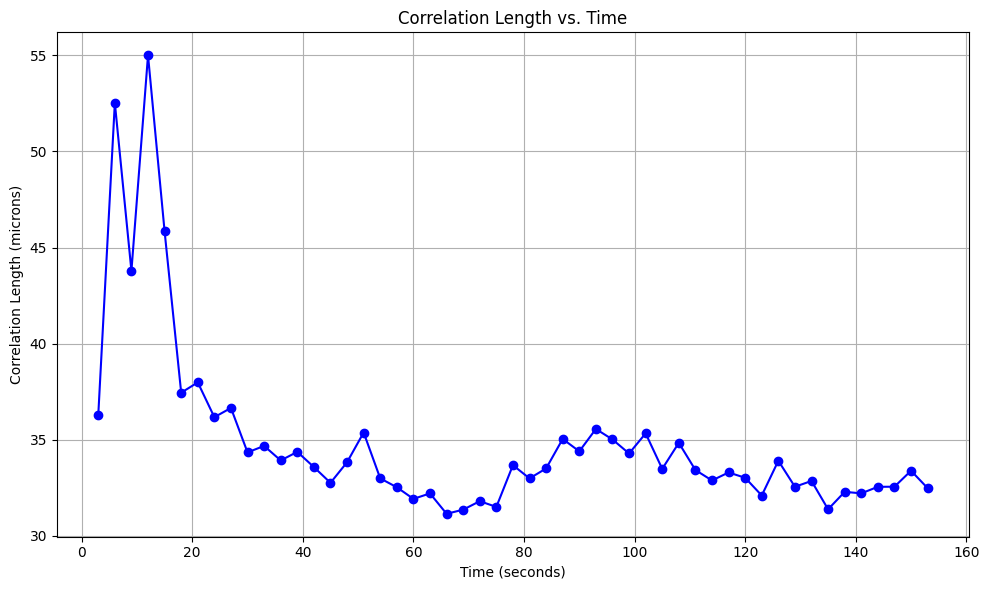

In [23]:
# Plotting correlation length vs. time using the DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df_correlation_lengths['time (seconds)'], df_correlation_lengths['correlation length'], '-o', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Correlation Length (microns)')
plt.title('Correlation Length vs. Time')
plt.grid(True)
plt.tight_layout()
plt.show()
